In [53]:
import warnings
import numpy as np
import pandas as pd
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import loguniform
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, precision_score, recall_score)
import xgboost as xgb
import optuna

%matplotlib inline

In [3]:
!ls data

test_data.csv
train_data.csv


---

1. Using the same data prep as in [here](https://www.kaggle.com/code/pmr3508202053/pmr3508-2020-53-classification-with-adult-dataset/notebook), try to replicate results of SVM, MLP, and Random Forest
2. Try to beat them with XGB
3. Optimize XGB with Optuna
4. Few tweaks to data prep
5. Run them all again

In [217]:
class DataPreper:
    atributosCAT = ['workclass', 'marital.status', 'occupation', 'race', 'sex', 'native.country']
    HigherCorrelation = ['age', 'education.num', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week']
    AtributosNUM = ['age', 'education.num', 'sex', 'hours.per.week']
    AtributosESPARSO = ['capital.gain', 'capital.loss']

    def __init__(self, file_path, is_test=False):
        self.df = pd.read_csv(file_path, index_col=['Id'], na_values="?")
        if not is_test:
            self.atributosCAT.append('income')
            self.HigherCorrelation.append('income')

    def fill_na_with_mode(self, s):
        return s.fillna(s.mode()[0])

    def run(self):
        for col in ['workclass', 'occupation', 'native.country']:
            self.df[col] = self.fill_na_with_mode(self.df[col])
        
        le = LabelEncoder()
        for col in self.atributosCAT:
            self.df[col] = le.fit_transform(self.df[col])
        
        return self.df[self.HigherCorrelation]

    def run_pipeline(self, df):
        PipelineNUM = Pipeline(steps=[('scaler', StandardScaler())])
        PipelineESPARSO = Pipeline(steps=[('scaler', RobustScaler())])
        Preprocessador = ColumnTransformer(transformers=[
            ('num', PipelineNUM, self.AtributosNUM),
            ('spr', PipelineESPARSO, self.AtributosESPARSO),
        ])
        return Preprocessador.fit_transform(df)

    def split(self, X_train, y_train):
        return train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [212]:
preper = DataPreper('data/train_data.csv')
train_df = preper.run()
y_train = train_df.pop('income')
X_train = train_df
X_train = preper.run_pipeline(X_train)
X_train, X_val, y_train, y_val = preper.split(X_train, y_train)
len(X_train), len(y_train), len(X_val), len(y_val)

(24420, 24420, 8140, 8140)

In [221]:
preper = DataPreper('data/test_data.csv', is_test=True)
test_df = preper.run()
test_df = preper.run_pipeline(test_df)
len(test_df)

16280

---

### Fitting same classifiers as link

#### Logistic Regression

In [19]:
logisticReg = LogisticRegression(solver="liblinear", random_state=42, **{'penalty': 'l1', 'C': 8.88888888888889})

In [20]:
logisticReg.fit(X_train, y_train)

LogisticRegression(C=8.88888888888889, penalty='l1', random_state=42,
                   solver='liblinear')

In [21]:
logisticReg.score(X_train, y_train)

0.821007371007371

not equal, but fairly close

#### SVM

In [22]:
svclass = SVC(probability=True, **{'kernel': 'rbf', 'gamma': 0.001, 'C': 3.8383838383838382})

In [23]:
svclass.fit(X_train, y_train)

SVC(C=3.8383838383838382, gamma=0.001, probability=True)

In [24]:
svclass.score(X_train, y_train)

0.8291564291564292

#### Random Forest

In [25]:
rfclass = RandomForestClassifier(random_state=42, **{'n_estimators': 580, 'max_depth': 10})

In [26]:
rfclass.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=580, random_state=42)

In [27]:
rfclass.score(X_train, y_train)

0.8522932022932023

#### Decision Tree

In [28]:
dtclass = DecisionTreeClassifier(random_state=42, **{'min_samples_split': 29, 'max_depth': 8, 'criterion': 'entropy'})

In [29]:
dtclass.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=29,
                       random_state=42)

In [30]:
dtclass.score(X_train, y_train)

0.837960687960688

#### MLP

In [31]:
mlp2l = MLPClassifier(early_stopping=True, **{
    'activation': 'relu',
    'alpha': 0.001310842476064518,
    'hidden_layer_sizes': (512, 256),
    'learning_rate': 'adaptive'
})

In [32]:
mlp2l.fit(X_train, y_train)

MLPClassifier(alpha=0.001310842476064518, early_stopping=True,
              hidden_layer_sizes=(512, 256), learning_rate='adaptive')

In [33]:
mlp2l.score(X_train, y_train)

0.8322276822276822

### CV Comp

In [34]:
def print_cv_metrics(classifier):
    y_pred = classifier.predict(X_val)
    auc = roc_auc_score(y_val, classifier.predict_proba(X_val)[:,1])
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print(f'{classifier} ->')
    print(f'AUC: {auc:.4f}')
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'recall: {rec:.4f}')
    print(f'F1: {f1:.4f}\n')
    display(ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred)).plot())
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'AUC': auc
    }

In [35]:
res_df = pd.DataFrame()

LogisticRegression(C=8.88888888888889, penalty='l1', random_state=42,
                   solver='liblinear') ->
AUC: 0.8486
Accuracy: 0.8264
Precision: 0.7199
recall: 0.4353
F1: 0.5426



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\999524755.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(logisticReg), index=['logRes']))


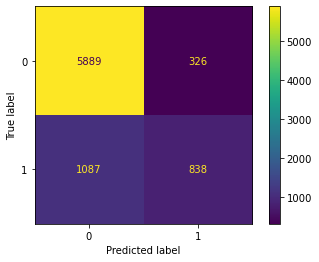

In [36]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(logisticReg), index=['logRes']))

SVC(C=3.8383838383838382, gamma=0.001, probability=True) ->
AUC: 0.8750
Accuracy: 0.8335
Precision: 0.9538
recall: 0.3112
F1: 0.4693



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\1036375701.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(svclass), index=['SVM']))


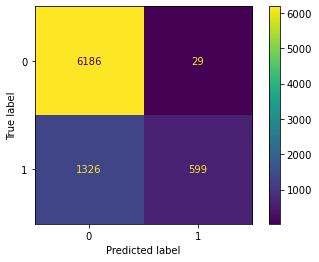

In [37]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(svclass), index=['SVM']))

RandomForestClassifier(max_depth=10, n_estimators=580, random_state=42) ->
AUC: 0.8842
Accuracy: 0.8506
Precision: 0.7918
recall: 0.4997
F1: 0.6127



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\2547662930.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(rfclass), index=['RandomForest']))


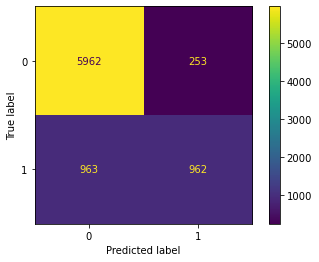

In [38]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(rfclass), index=['RandomForest']))

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=29,
                       random_state=42) ->
AUC: 0.8669
Accuracy: 0.8435
Precision: 0.7350
recall: 0.5288
F1: 0.6151



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\666425070.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(dtclass), index=['DecisionTree']))


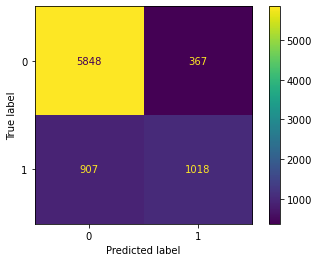

In [39]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(dtclass), index=['DecisionTree']))

MLPClassifier(alpha=0.001310842476064518, early_stopping=True,
              hidden_layer_sizes=(512, 256), learning_rate='adaptive') ->
AUC: 0.8659
Accuracy: 0.8311
Precision: 0.6856
recall: 0.5278
F1: 0.5964



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\2930082413.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(mlp2l), index=['MLP']))


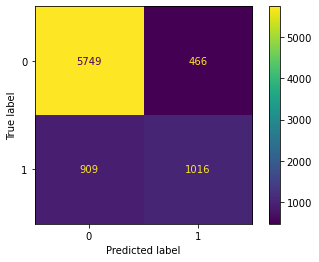

In [40]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(mlp2l), index=['MLP']))

In [41]:
res_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1,AUC
DecisionTree,0.843489,0.735018,0.528831,0.615106,0.866863
RandomForest,0.850614,0.791770,0.499740,0.612739,0.884216
MLP,0.831081,0.685560,0.527792,0.596419,0.865930
logRes,0.826413,0.719931,0.435325,0.542570,0.848562
SVM,0.833538,0.953822,0.311169,0.469252,0.875026


### Trying XGB

In [42]:
booster = xgb.XGBClassifier()

In [43]:
booster.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [44]:
booster.score(X_train, y_train)

0.8614660114660114

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) ->
AUC: 0.8951
Accuracy: 0.8566
Precision: 0.7880
recall: 0.5387
F1: 0.6399



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\3773494989.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(booster), index=['XGB default']))


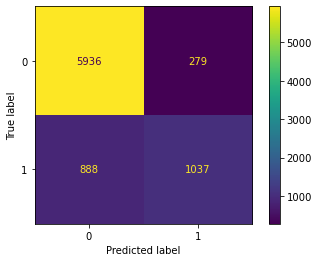

In [45]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(booster), index=['XGB default']))

In [46]:
res_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1,AUC
XGB default,0.856634,0.787994,0.538701,0.639926,0.895065
DecisionTree,0.843489,0.735018,0.528831,0.615106,0.866863
RandomForest,0.850614,0.791770,0.499740,0.612739,0.884216
MLP,0.831081,0.685560,0.527792,0.596419,0.865930
logRes,0.826413,0.719931,0.435325,0.542570,0.848562
SVM,0.833538,0.953822,0.311169,0.469252,0.875026


### Optimize XGB with optuna

In [136]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

In [179]:
def objective(score_function, trial):
    param = {
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'verbosity': 0,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'scale_pos_weight': trial.suggest_float('min_child_weight', 1e-1, 10)
    }
    pruner = optuna.integration.XGBoostPruningCallback(trial, 'validation-auc')
    booster = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], callbacks=[pruner], verbose_eval=False)
    return score_function(y_val, booster.predict(dvalid).round())

In [180]:
objective_accuracy = partial(objective, accuracy_score)
objective_f1 = partial(objective, f1_score)

In [181]:
def make_booster(params):
    booster = xgb.XGBClassifier(**params)
    booster.fit(X_train, y_train)
    train_score = booster.score(X_train, y_train)
    print(f'{train_score=}')
    return booster

In [182]:
def optimize_params(objective_function):
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=30, n_warmup_steps=30, interval_steps=10
        )
    )
    study.optimize(objective_function, n_trials=300)
    return study.best_params

In [183]:
acc_opt_booster = make_booster(optimize_params(objective_accuracy))

[I 2022-05-29 22:51:00,976] A new study created in memory with name: no-name-b742286b-ead2-4271-8713-c22e4a64e83c
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:01,033] Trial 0 finished with value: 0.7518427518427518 and parameters: {'booster': 'dart', 'lambda': 0.00981017203853039, 'alpha': 2.8809996304291282e-06, 'learning_rate': 0.27388585135699006, 'gamma': 0.02191919066914053, 'n_estimators': 805, 'max_depth': 6, 'min_child_weight': 4.0168541585749935}. Best is trial 0 with value: 0.7518427518427518.
C:\Users\Lucas\anaconda3\lib\site-packages\

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:01,457] Trial 10 finished with value: 0.8046683046683046 and parameters: {'booster': 'dart', 'lambda': 0.6049103262894152, 'alpha': 1.8418208777498805e-08, 'learning_rate': 0.010468110147581233, 'gamma': 0.0031448158171672323, 'n_estimators': 993, 'max_depth': 1, 'min_child_weight': 0.19408475630939526}. Best is trial 7 with value: 0.8367321867321867.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_chil

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:02,129] Trial 20 finished with value: 0.806019656019656 and parameters: {'booster': 'gbtree', 'lambda': 1.0226885905497061e-05, 'alpha': 0.023876016316499465, 'learning_rate': 0.7951381776872917, 'gamma': 704.0700112133557, 'n_estimators': 903, 'max_depth': 5, 'min_child_weight': 0.7395068116912871}. Best is trial 19 with value: 0.8503685503685504.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_w

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:02,889] Trial 30 finished with value: 0.7441031941031941 and parameters: {'booster': 'dart', 'lambda': 0.00035458058748794193, 'alpha': 4.402135660344747e-06, 'learning_rate': 0.1320338715897722, 'gamma': 2.2198678609160467, 'n_estimators': 912, 'max_depth': 10, 'min_child_weight': 4.500196369262152}. Best is trial 19 with value: 0.8503685503685504.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:03,774] Trial 40 finished with value: 0.8194103194103194 and parameters: {'booster': 'dart', 'lambda': 0.001126013834157908, 'alpha': 0.00691021312097727, 'learning_rate': 0.31780702692183016, 'gamma': 0.009789907449279725, 'n_estimators': 334, 'max_depth': 9, 'min_child_weight': 2.330890047288915}. Best is trial 34 with value: 0.8517199017199018.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_we

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:04,607] Trial 50 finished with value: 0.8496314496314497 and parameters: {'booster': 'dart', 'lambda': 0.06150918321709599, 'alpha': 6.365412888600008e-05, 'learning_rate': 0.29218809038518645, 'gamma': 2.2722640026572396, 'n_estimators': 636, 'max_depth': 8, 'min_child_weight': 1.4920117469102872}. Best is trial 41 with value: 0.8529484029484029.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_we

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:05,420] Trial 60 finished with value: 0.8422604422604423 and parameters: {'booster': 'dart', 'lambda': 6.710297486415523e-07, 'alpha': 9.434870439653955e-08, 'learning_rate': 0.3664425936888939, 'gamma': 0.6888333082067427, 'n_estimators': 949, 'max_depth': 5, 'min_child_weight': 0.6674253001364978}. Best is trial 55 with value: 0.8534398034398034.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_w

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:06,277] Trial 70 finished with value: 0.8131449631449631 and parameters: {'booster': 'dart', 'lambda': 0.09465052054465777, 'alpha': 3.152018003034063e-05, 'learning_rate': 0.39237635191004355, 'gamma': 594.4409654309957, 'n_estimators': 425, 'max_depth': 8, 'min_child_weight': 0.7259342025500972}. Best is trial 64 with value: 0.8552825552825553.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_wei

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:07,203] Trial 80 finished with value: 0.6907862407862407 and parameters: {'booster': 'dart', 'lambda': 0.07046051368849127, 'alpha': 2.008559003507931e-06, 'learning_rate': 0.02202546299802369, 'gamma': 309.9799430253878, 'n_estimators': 593, 'max_depth': 8, 'min_child_weight': 5.435380289529672}. Best is trial 64 with value: 0.8552825552825553.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weig

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:08,127] Trial 90 finished with value: 0.7723587223587224 and parameters: {'booster': 'dart', 'lambda': 0.08166277537092573, 'alpha': 5.079079447566973e-06, 'learning_rate': 0.3387955068648234, 'gamma': 0.0008622530477443228, 'n_estimators': 430, 'max_depth': 10, 'min_child_weight': 4.010961395386727}. Best is trial 82 with value: 0.8557739557739558.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:09,054] Trial 100 finished with value: 0.8149877149877149 and parameters: {'booster': 'gblinear', 'lambda': 0.6362122192794929, 'alpha': 3.819510659716301e-08, 'learning_rate': 0.25980427089256763, 'gamma': 2.345400091540407, 'n_estimators': 347, 'max_depth': 9, 'min_child_weight': 1.1949072020067488}. Best is trial 82 with value: 0.8557739557739558.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:10,014] Trial 110 finished with value: 0.7524570024570024 and parameters: {'booster': 'dart', 'lambda': 0.03148018545056308, 'alpha': 2.994975131371521e-05, 'learning_rate': 0.4085803558914925, 'gamma': 1.8183027832573735, 'n_estimators': 85, 'max_depth': 9, 'min_child_weight': 4.585622847219621}. Best is trial 82 with value: 0.8557739557739558.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weig

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:10,975] Trial 120 finished with value: 0.8337837837837838 and parameters: {'booster': 'gbtree', 'lambda': 0.005032380867184258, 'alpha': 5.406385395288384e-05, 'learning_rate': 0.5745185778703081, 'gamma': 1.8878577695881822, 'n_estimators': 129, 'max_depth': 9, 'min_child_weight': 2.062355539337477}. Best is trial 82 with value: 0.8557739557739558.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_

[I 2022-05-29 22:51:11,771] Trial 129 finished with value: 0.8539312039312039 and parameters: {'booster': 'gbtree', 'lambda': 0.08442673439518522, 'alpha': 2.1167711115513847e-06, 'learning_rate': 0.49657349517487376, 'gamma': 6.603179606568674, 'n_estimators': 90, 'max_depth': 9, 'min_child_weight': 0.8164222844482553}. Best is trial 82 with value: 0.8557739557739558.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:11,860] Trial 130 finished with value: 0.82997542997543 and parameters: {'booster': 'gbtree', 'lambda': 0.03730575438703158, 'alpha': 3

[I 2022-05-29 22:51:12,585] Trial 139 finished with value: 0.8556511056511057 and parameters: {'booster': 'gbtree', 'lambda': 0.2805736476281677, 'alpha': 3.538794595394733e-07, 'learning_rate': 0.6511309987196526, 'gamma': 4.180225880988646, 'n_estimators': 103, 'max_depth': 9, 'min_child_weight': 0.8205194184257403}. Best is trial 134 with value: 0.8567567567567568.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:12,669] Trial 140 finished with value: 0.855036855036855 and parameters: {'booster': 'gbtree', 'lambda': 0.2048355588364878, 'alpha': 3.

[I 2022-05-29 22:51:13,452] Trial 149 finished with value: 0.8035626535626536 and parameters: {'booster': 'gbtree', 'lambda': 0.08755376618137366, 'alpha': 6.136065425261903e-08, 'learning_rate': 0.7534532484751144, 'gamma': 2.2687222192680774, 'n_estimators': 14, 'max_depth': 9, 'min_child_weight': 0.012211458239354323}. Best is trial 143 with value: 0.8568796068796068.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:13,542] Trial 150 finished with value: 0.8358722358722359 and parameters: {'booster': 'gbtree', 'lambda': 0.302047887067273, 'alpha':

[I 2022-05-29 22:51:14,276] Trial 159 finished with value: 0.8427518427518428 and parameters: {'booster': 'gbtree', 'lambda': 0.041319114524185276, 'alpha': 1.0257365197467392e-06, 'learning_rate': 0.9972020457918388, 'gamma': 3.2806198554156034, 'n_estimators': 32, 'max_depth': 8, 'min_child_weight': 0.42818777127295116}. Best is trial 151 with value: 0.8571253071253071.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:14,359] Trial 160 finished with value: 0.8530712530712531 and parameters: {'booster': 'gbtree', 'lambda': 0.20526835629410725, 'alph

[I 2022-05-29 22:51:15,062] Trial 169 finished with value: 0.75995085995086 and parameters: {'booster': 'gbtree', 'lambda': 0.11055762445918565, 'alpha': 1.7608428588267094e-07, 'learning_rate': 0.9181193271945212, 'gamma': 16.43541508499823, 'n_estimators': 10, 'max_depth': 8, 'min_child_weight': 3.6306775014531745}. Best is trial 151 with value: 0.8571253071253071.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:15,153] Trial 170 finished with value: 0.845945945945946 and parameters: {'booster': 'gbtree', 'lambda': 0.045475920354129326, 'alpha': 9

[I 2022-05-29 22:51:15,903] Trial 179 finished with value: 0.8540540540540541 and parameters: {'booster': 'gbtree', 'lambda': 0.28210385282565603, 'alpha': 4.725754253641535e-08, 'learning_rate': 0.9203013322126843, 'gamma': 12.149302796283637, 'n_estimators': 83, 'max_depth': 10, 'min_child_weight': 1.144888853489248}. Best is trial 151 with value: 0.8571253071253071.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:15,984] Trial 180 finished with value: 0.8531941031941032 and parameters: {'booster': 'gbtree', 'lambda': 0.6823534758974767, 'alpha': 

[I 2022-05-29 22:51:16,731] Trial 189 finished with value: 0.8542997542997544 and parameters: {'booster': 'gbtree', 'lambda': 0.2722972808929502, 'alpha': 7.089559877543937e-08, 'learning_rate': 0.905475219970359, 'gamma': 7.3695159162455415, 'n_estimators': 52, 'max_depth': 9, 'min_child_weight': 1.1966839902942599}. Best is trial 151 with value: 0.8571253071253071.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:16,814] Trial 190 finished with value: 0.8522113022113023 and parameters: {'booster': 'gbtree', 'lambda': 0.5175717227666511, 'alpha': 6.

[I 2022-05-29 22:51:17,564] Trial 199 finished with value: 0.8501228501228502 and parameters: {'booster': 'gbtree', 'lambda': 0.28319519113731156, 'alpha': 1.1460629430664432e-06, 'learning_rate': 0.7825866107316428, 'gamma': 2.120593319704894, 'n_estimators': 79, 'max_depth': 8, 'min_child_weight': 1.3648746896757162}. Best is trial 151 with value: 0.8571253071253071.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:17,686] Trial 200 finished with value: 0.8496314496314497 and parameters: {'booster': 'gbtree', 'lambda': 0.2186485095200791, 'alpha': 

[I 2022-05-29 22:51:18,462] Trial 209 finished with value: 0.8481572481572481 and parameters: {'booster': 'gbtree', 'lambda': 0.20248657224640756, 'alpha': 3.073445239500985e-08, 'learning_rate': 0.9967376363813346, 'gamma': 4.683326405633106, 'n_estimators': 47, 'max_depth': 9, 'min_child_weight': 1.4714184765294924}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:18,549] Trial 210 finished with value: 0.8545454545454545 and parameters: {'booster': 'gbtree', 'lambda': 0.0004074493696487194, 'alpha'

[I 2022-05-29 22:51:19,329] Trial 219 finished with value: 0.8535626535626536 and parameters: {'booster': 'gbtree', 'lambda': 1.718218483951196e-05, 'alpha': 2.3724077501403733e-08, 'learning_rate': 0.827767798230519, 'gamma': 5.755623029091511, 'n_estimators': 80, 'max_depth': 9, 'min_child_weight': 0.669201362273861}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:19,414] Trial 220 finished with value: 0.7423832923832924 and parameters: {'booster': 'gbtree', 'lambda': 4.797480840816778e-06, 'alpha

[I 2022-05-29 22:51:20,121] Trial 229 finished with value: 0.8565110565110565 and parameters: {'booster': 'gbtree', 'lambda': 3.5313833307565046e-08, 'alpha': 8.423732352170311e-08, 'learning_rate': 0.8370835009819878, 'gamma': 5.609621027505598, 'n_estimators': 166, 'max_depth': 9, 'min_child_weight': 1.1054586473245231}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:20,201] Trial 230 finished with value: 0.8512285012285012 and parameters: {'booster': 'gbtree', 'lambda': 1.9907648218600828e-07, 'a

[I 2022-05-29 22:51:20,949] Trial 239 finished with value: 0.8061425061425062 and parameters: {'booster': 'gbtree', 'lambda': 6.914341762126376e-06, 'alpha': 1.4444171041040112e-07, 'learning_rate': 0.16100177903466528, 'gamma': 9.12812204067124, 'n_estimators': 82, 'max_depth': 1, 'min_child_weight': 0.8182342525475339}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:21,036] Trial 240 finished with value: 0.8540540540540541 and parameters: {'booster': 'gbtree', 'lambda': 5.176567922694367e-08, 'alp

[I 2022-05-29 22:51:21,796] Trial 249 finished with value: 0.8547911547911548 and parameters: {'booster': 'gbtree', 'lambda': 2.0362253096661735e-06, 'alpha': 2.780657924530778e-08, 'learning_rate': 0.9991002221911296, 'gamma': 4.401997745138916, 'n_estimators': 69, 'max_depth': 9, 'min_child_weight': 0.9943966580358518}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:21,884] Trial 250 finished with value: 0.8496314496314497 and parameters: {'booster': 'gbtree', 'lambda': 7.87872887231012e-07, 'alph

[I 2022-05-29 22:51:22,648] Trial 259 finished with value: 0.8541769041769042 and parameters: {'booster': 'gbtree', 'lambda': 1.9528503268940712e-06, 'alpha': 1.4619351553783517e-07, 'learning_rate': 0.8945673685740885, 'gamma': 7.81539428783181, 'n_estimators': 86, 'max_depth': 9, 'min_child_weight': 0.7988853108467848}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:22,745] Trial 260 finished with value: 0.8530712530712531 and parameters: {'booster': 'gbtree', 'lambda': 7.203074712296497e-07, 'alp

[I 2022-05-29 22:51:23,581] Trial 269 finished with value: 0.8414004914004914 and parameters: {'booster': 'gbtree', 'lambda': 3.596603041975731e-06, 'alpha': 1.531138820987108e-06, 'learning_rate': 0.8180848332404906, 'gamma': 19.801579337469754, 'n_estimators': 25, 'max_depth': 9, 'min_child_weight': 0.574695870344002}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:23,674] Trial 270 finished with value: 0.8390663390663391 and parameters: {'booster': 'gbtree', 'lambda': 0.001485618407804646, 'alpha

[I 2022-05-29 22:51:24,444] Trial 279 finished with value: 0.857002457002457 and parameters: {'booster': 'gbtree', 'lambda': 0.0001115431513816104, 'alpha': 4.3215968838580615e-08, 'learning_rate': 0.9998573025120018, 'gamma': 10.29791602823456, 'n_estimators': 88, 'max_depth': 9, 'min_child_weight': 1.0683859972959378}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:24,543] Trial 280 finished with value: 0.8461916461916462 and parameters: {'booster': 'gbtree', 'lambda': 2.3831008434430044e-05, 'alp

[I 2022-05-29 22:51:25,337] Trial 289 finished with value: 0.8547911547911548 and parameters: {'booster': 'gbtree', 'lambda': 0.0006448296548658331, 'alpha': 1.1713314005173913e-07, 'learning_rate': 0.9041963280893731, 'gamma': 11.138655646640412, 'n_estimators': 128, 'max_depth': 8, 'min_child_weight': 1.0867122692799076}. Best is trial 204 with value: 0.8576167076167076.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:25,427] Trial 290 finished with value: 0.8528255528255528 and parameters: {'booster': 'gbtree', 'lambda': 5.275562581425577e-06, 'a

[I 2022-05-29 22:51:26,216] Trial 299 finished with value: 0.8518427518427518 and parameters: {'booster': 'gbtree', 'lambda': 3.4283751802639035e-06, 'alpha': 2.1497098770850074e-07, 'learning_rate': 0.8540102746760672, 'gamma': 3.555592665266031, 'n_estimators': 10, 'max_depth': 9, 'min_child_weight': 1.343698639349039}. Best is trial 204 with value: 0.8576167076167076.


train_score=0.8544635544635545


In [184]:
acc_opt_booster

XGBClassifier(alpha=4.106228642077862e-08, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=5.605279390874427, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=0.15035296866251563, learning_rate=0.8488459925814333,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=9,
              max_leaves=0, min_child_weight=0.9982121205733772, missing=nan,
              monotone_constraints='()', n_estimators=78, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

XGBClassifier(alpha=4.106228642077862e-08, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=5.605279390874427, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=0.15035296866251563, learning_rate=0.8488459925814333,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=9,
              max_leaves=0, min_child_weight=0.9982121205733772, missing=nan,
              monotone_constraints='()', n_estimators=78, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...) ->
AUC: 0.8921
Accuracy: 0.8557
Precision: 0.7733
recall: 0.5512
F1: 0.6436



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\1940732585.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(acc_opt_booster), index=['XGB optimized for accuracy']))


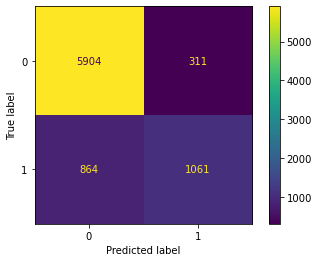

In [185]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(acc_opt_booster), index=['XGB optimized for accuracy']))

In [186]:
f1_opt_booster = make_booster(optimize_params(objective_f1))

[I 2022-05-29 22:51:56,321] A new study created in memory with name: no-name-2de7bf98-5916-43e8-81c3-bc7fa87a7606
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:56,347] Trial 0 finished with value: 0.5006134969325153 and parameters: {'booster': 'gblinear', 'lambda': 3.8912220307700976e-06, 'alpha': 2.1706929092369829e-07, 'learning_rate': 0.29383434819015775, 'gamma': 0.17176503893215875, 'n_estimators': 684, 'max_depth': 4, 'min_child_weight': 9.578909317247284}. Best is trial 0 with value: 0.5006134969325153.
C:\Users\Lucas\anaconda3\lib\site-pac

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:56,740] Trial 10 finished with value: 0.2995594713656388 and parameters: {'booster': 'dart', 'lambda': 0.0007251266808861495, 'alpha': 0.9531301369604607, 'learning_rate': 0.010826379427587882, 'gamma': 2.4630190448217855e-05, 'n_estimators': 740, 'max_depth': 1, 'min_child_weight': 0.04039836318830625}. Best is trial 5 with value: 0.6447517569712083.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_chil

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:57,569] Trial 20 finished with value: 0.6187138067662298 and parameters: {'booster': 'dart', 'lambda': 0.6902909174113133, 'alpha': 3.0954906335829325e-07, 'learning_rate': 0.05476663813473223, 'gamma': 0.00011107224100576172, 'n_estimators': 670, 'max_depth': 8, 'min_child_weight': 1.2732041810578434}. Best is trial 5 with value: 0.6447517569712083.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:58,533] Trial 30 finished with value: 0.6068915749594083 and parameters: {'booster': 'dart', 'lambda': 1.169615414644857e-05, 'alpha': 0.21746920505022838, 'learning_rate': 0.6622216997787013, 'gamma': 126.58012475220771, 'n_estimators': 426, 'max_depth': 10, 'min_child_weight': 4.6856913730617356}. Best is trial 23 with value: 0.6714068054850179.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_we

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:51:59,332] Trial 40 finished with value: 0.4410368747718145 and parameters: {'booster': 'gblinear', 'lambda': 0.3798585553715388, 'alpha': 2.044181699941747e-05, 'learning_rate': 0.09637030463302891, 'gamma': 1.9597347022737446, 'n_estimators': 402, 'max_depth': 9, 'min_child_weight': 1.5510513577731393}. Best is trial 32 with value: 0.6716417910447762.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:00,262] Trial 50 finished with value: 0.5567200986436499 and parameters: {'booster': 'dart', 'lambda': 0.00015513866785121544, 'alpha': 0.936802968371629, 'learning_rate': 0.23215751959061992, 'gamma': 0.0016750113408887275, 'n_estimators': 551, 'max_depth': 9, 'min_child_weight': 8.418175805198565}. Best is trial 42 with value: 0.67622343054869.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_wei

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:01,133] Trial 60 finished with value: 0.5629397967161844 and parameters: {'booster': 'gbtree', 'lambda': 1.9333064796793338e-08, 'alpha': 0.0547037061077825, 'learning_rate': 0.5733473999671045, 'gamma': 0.013718956699225146, 'n_estimators': 619, 'max_depth': 4, 'min_child_weight': 7.617076126836125}. Best is trial 42 with value: 0.67622343054869.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_we

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:01,943] Trial 70 finished with value: 0.6777862016679302 and parameters: {'booster': 'gbtree', 'lambda': 0.9514301698695143, 'alpha': 0.007882202079210985, 'learning_rate': 0.5200197111110227, 'gamma': 0.9824177821412587, 'n_estimators': 483, 'max_depth': 8, 'min_child_weight': 1.8308669444118775}. Best is trial 70 with value: 0.6777862016679302.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_wei

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:02,646] Trial 80 finished with value: 0.614481409001957 and parameters: {'booster': 'gbtree', 'lambda': 0.9567296206067071, 'alpha': 0.0016314251547936728, 'learning_rate': 0.7608831542258641, 'gamma': 2.7178096139314314, 'n_estimators': 612, 'max_depth': 5, 'min_child_weight': 0.8053723733126394}. Best is trial 76 with value: 0.6791967044284243.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_wei

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:03,312] Trial 90 finished with value: 0.6224459579508439 and parameters: {'booster': 'gbtree', 'lambda': 0.09376423415607985, 'alpha': 7.444043074515741e-06, 'learning_rate': 0.04023421774435576, 'gamma': 0.267439799747192, 'n_estimators': 530, 'max_depth': 6, 'min_child_weight': 1.7957411356016768}. Best is trial 76 with value: 0.6791967044284243.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_w

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:04,039] Trial 100 finished with value: 0.6651130272663714 and parameters: {'booster': 'gbtree', 'lambda': 5.360853924880364e-06, 'alpha': 0.00040740156145467875, 'learning_rate': 0.6345909362867576, 'gamma': 0.1290874472226982, 'n_estimators': 987, 'max_depth': 5, 'min_child_weight': 2.175971752990114}. Best is trial 76 with value: 0.6791967044284243.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_chil

[I 2022-05-29 22:52:04,639] Trial 109 finished with value: 0.6711039706219876 and parameters: {'booster': 'gbtree', 'lambda': 1.518289298178069e-07, 'alpha': 1.7529373752624872e-06, 'learning_rate': 0.8349356356488729, 'gamma': 1.5024633369867268, 'n_estimators': 851, 'max_depth': 6, 'min_child_weight': 2.1827902156700607}. Best is trial 102 with value: 0.6802005012531328.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:04,703] Trial 110 finished with value: 0.5940257976917854 and parameters: {'booster': 'gbtree', 'lambda': 2.8283738172969885e-06, '

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:05,431] Trial 120 finished with value: 0.6422476586888658 and parameters: {'booster': 'gbtree', 'lambda': 4.913160984813326e-06, 'alpha': 0.014077846463889317, 'learning_rate': 0.4357687671498016, 'gamma': 0.9905774859357446, 'n_estimators': 1000, 'max_depth': 5, 'min_child_weight': 2.880485954923569}. Best is trial 102 with value: 0.6802005012531328.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_chil

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:06,114] Trial 130 finished with value: 0.6541755888650964 and parameters: {'booster': 'gbtree', 'lambda': 1.205685886378712e-05, 'alpha': 7.952736336256684e-05, 'learning_rate': 0.724902951234832, 'gamma': 0.902061602962845, 'n_estimators': 931, 'max_depth': 4, 'min_child_weight': 1.720192001318937}. Best is trial 102 with value: 0.6802005012531328.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:06,786] Trial 140 finished with value: 0.5903067020068157 and parameters: {'booster': 'gblinear', 'lambda': 1.4951675692795884e-07, 'alpha': 5.568179515745547e-06, 'learning_rate': 0.3801105982651257, 'gamma': 4.2263128046488925, 'n_estimators': 630, 'max_depth': 6, 'min_child_weight': 3.7601994740855704}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_

[I 2022-05-29 22:52:07,416] Trial 149 finished with value: 0.5706051873198847 and parameters: {'booster': 'gbtree', 'lambda': 1.6611065958908379e-07, 'alpha': 1.261611607089015e-05, 'learning_rate': 0.6887946430851294, 'gamma': 2.7932192929207056, 'n_estimators': 796, 'max_depth': 5, 'min_child_weight': 7.1893274012312895}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:07,485] Trial 150 finished with value: 0.6564589174034936 and parameters: {'booster': 'gbtree', 'lambda': 7.950136856258183e-08, 'a

[I 2022-05-29 22:52:08,104] Trial 159 finished with value: 0.6643243243243243 and parameters: {'booster': 'gbtree', 'lambda': 0.0001237093117006134, 'alpha': 1.604227112896379e-05, 'learning_rate': 0.7883496588870379, 'gamma': 5.850798866769896, 'n_estimators': 741, 'max_depth': 6, 'min_child_weight': 1.7186261548013235}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:08,178] Trial 160 finished with value: 0.6669735327963177 and parameters: {'booster': 'gbtree', 'lambda': 0.8871505267248051, 'alpha'

C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:08,908] Trial 170 finished with value: 0.6621175434734757 and parameters: {'booster': 'dart', 'lambda': 2.980101899308974e-06, 'alpha': 1.1961524084817085e-05, 'learning_rate': 0.787141064212157, 'gamma': 0.19260610369632564, 'n_estimators': 855, 'max_depth': 6, 'min_child_weight': 2.6448727923411743}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_chil

[I 2022-05-29 22:52:09,604] Trial 179 finished with value: 0.6678733031674208 and parameters: {'booster': 'gbtree', 'lambda': 5.753975319950894e-07, 'alpha': 1.5243938002689572e-05, 'learning_rate': 0.7088201454694665, 'gamma': 2.5271662687818717, 'n_estimators': 882, 'max_depth': 7, 'min_child_weight': 2.459811276514071}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:09,675] Trial 180 finished with value: 0.6666666666666667 and parameters: {'booster': 'gbtree', 'lambda': 0.2859145822736774, 'alpha

[I 2022-05-29 22:52:10,392] Trial 189 finished with value: 0.6761290322580645 and parameters: {'booster': 'dart', 'lambda': 1.3863317998724541e-06, 'alpha': 0.00016952699518407458, 'learning_rate': 0.944813811562801, 'gamma': 0.5110766469885595, 'n_estimators': 926, 'max_depth': 7, 'min_child_weight': 1.6214279400467935}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:10,481] Trial 190 finished with value: 0.647515081873025 and parameters: {'booster': 'dart', 'lambda': 1.8446864567328051e-06, 'alpha

[I 2022-05-29 22:52:11,323] Trial 199 finished with value: 0.6104997293884177 and parameters: {'booster': 'dart', 'lambda': 1.139810263365761e-06, 'alpha': 5.6466676126049724e-05, 'learning_rate': 0.8036368594069103, 'gamma': 0.09955282217578133, 'n_estimators': 981, 'max_depth': 6, 'min_child_weight': 5.282469158112848}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:11,420] Trial 200 finished with value: 0.6611098925202895 and parameters: {'booster': 'dart', 'lambda': 7.993536969913625e-07, 'alpha

[I 2022-05-29 22:52:12,241] Trial 209 finished with value: 0.6742886178861789 and parameters: {'booster': 'dart', 'lambda': 7.906543440338048e-07, 'alpha': 5.6601869927451054e-05, 'learning_rate': 0.6653580839796575, 'gamma': 0.08525689490398976, 'n_estimators': 957, 'max_depth': 7, 'min_child_weight': 1.8150901073114483}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:12,330] Trial 210 finished with value: 0.6714023831347388 and parameters: {'booster': 'dart', 'lambda': 0.6492442030275551, 'alpha':

[I 2022-05-29 22:52:13,140] Trial 219 finished with value: 0.6608154020385051 and parameters: {'booster': 'dart', 'lambda': 1.5828948189961715e-06, 'alpha': 7.68786465459455e-05, 'learning_rate': 0.7041386045476774, 'gamma': 0.35675383521301907, 'n_estimators': 487, 'max_depth': 6, 'min_child_weight': 1.4870150008491683}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:13,196] Trial 220 finished with value: 0.6161980293198751 and parameters: {'booster': 'gblinear', 'lambda': 1.0623018776973983e-06, '

[I 2022-05-29 22:52:14,008] Trial 229 finished with value: 0.674209308305477 and parameters: {'booster': 'dart', 'lambda': 9.972664463266591e-07, 'alpha': 0.0001992107903932821, 'learning_rate': 0.6664389390809949, 'gamma': 0.434285226346307, 'n_estimators': 879, 'max_depth': 6, 'min_child_weight': 1.9482463285142546}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:14,084] Trial 230 finished with value: 0.6454841130848136 and parameters: {'booster': 'gbtree', 'lambda': 1.7677603595660826e-06, 'alpha

[I 2022-05-29 22:52:14,822] Trial 239 finished with value: 0.6278935185185185 and parameters: {'booster': 'gbtree', 'lambda': 2.1844763304105017e-06, 'alpha': 0.0001468148803779661, 'learning_rate': 0.042454317370518004, 'gamma': 2.093866003656444, 'n_estimators': 947, 'max_depth': 7, 'min_child_weight': 1.9981097702311055}. Best is trial 133 with value: 0.6806045340050377.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:14,896] Trial 240 finished with value: 0.6776315789473684 and parameters: {'booster': 'gbtree', 'lambda': 1.0094804129865413e-06, 

[I 2022-05-29 22:52:15,575] Trial 249 finished with value: 0.6690510252742012 and parameters: {'booster': 'gbtree', 'lambda': 0.621156287155194, 'alpha': 0.015346030765591975, 'learning_rate': 0.6751913467079985, 'gamma': 4.453380205526783, 'n_estimators': 836, 'max_depth': 6, 'min_child_weight': 2.051275451820058}. Best is trial 247 with value: 0.6824762855716426.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:15,653] Trial 250 finished with value: 0.6674172483674847 and parameters: {'booster': 'gbtree', 'lambda': 2.2693630921872084e-06, 'alpha': 

[I 2022-05-29 22:52:16,385] Trial 259 finished with value: 0.6529411764705881 and parameters: {'booster': 'gbtree', 'lambda': 5.74018206720535e-06, 'alpha': 0.005076439067691527, 'learning_rate': 0.6810063713826204, 'gamma': 4.103580942702577, 'n_estimators': 829, 'max_depth': 6, 'min_child_weight': 1.308749885007356}. Best is trial 247 with value: 0.6824762855716426.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:16,463] Trial 260 finished with value: 0.676175382989963 and parameters: {'booster': 'gbtree', 'lambda': 1.2983624117327126e-06, 'alpha'

[I 2022-05-29 22:52:17,147] Trial 269 finished with value: 0.6612859833198816 and parameters: {'booster': 'gbtree', 'lambda': 9.337740427639711e-07, 'alpha': 0.0015262556422148293, 'learning_rate': 0.8547371562608942, 'gamma': 9.60677737321812, 'n_estimators': 783, 'max_depth': 6, 'min_child_weight': 1.6763902137337896}. Best is trial 247 with value: 0.6824762855716426.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:17,225] Trial 270 finished with value: 0.6534700691628905 and parameters: {'booster': 'gbtree', 'lambda': 0.974475200465064, 'alpha': 

[I 2022-05-29 22:52:17,975] Trial 279 finished with value: 0.6684709066305818 and parameters: {'booster': 'dart', 'lambda': 1.6641569094463234e-06, 'alpha': 1.759617288003136e-05, 'learning_rate': 0.8271534026841467, 'gamma': 0.5904157806553687, 'n_estimators': 872, 'max_depth': 5, 'min_child_weight': 1.6431988354594629}. Best is trial 247 with value: 0.6824762855716426.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:18,061] Trial 280 finished with value: 0.6556674523248339 and parameters: {'booster': 'dart', 'lambda': 3.4259035558207067e-06, 'alph

[I 2022-05-29 22:52:18,814] Trial 289 finished with value: 0.6755399296835761 and parameters: {'booster': 'gbtree', 'lambda': 1.0871732742377672e-06, 'alpha': 0.000491089983957962, 'learning_rate': 0.9324234292137992, 'gamma': 0.6066516853511436, 'n_estimators': 750, 'max_depth': 6, 'min_child_weight': 1.9706830352004772}. Best is trial 247 with value: 0.6824762855716426.
C:\Users\Lucas\anaconda3\lib\site-packages\optuna\trial\_trial.py:772: RuntimeWarning: Inconsistent parameter values for distribution with name "min_child_weight"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more then once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'low': 0.0, 'high': 10.0}
  warnings.warn(
[I 2022-05-29 22:52:18,909] Trial 290 finished with value: 0.5306420944858856 and parameters: {'booster': 'dart', 'lambda': 1.0210080091731979e-05, 'alp

[I 2022-05-29 22:52:19,552] Trial 299 finished with value: 0.5622864243553899 and parameters: {'booster': 'gblinear', 'lambda': 0.00020856827898943365, 'alpha': 0.009236338091788174, 'learning_rate': 0.7894434166020938, 'gamma': 0.22056432165392176, 'n_estimators': 665, 'max_depth': 6, 'min_child_weight': 1.254126366360374}. Best is trial 291 with value: 0.6830785177507125.


train_score=0.8641277641277642


In [187]:
f1_opt_booster

XGBClassifier(alpha=6.945537162926513e-05, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.2934613765587281, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=4.256585132196874e-06, learning_rate=0.8064765229593596,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=1.8201673536211522, missing=nan,
              monotone_constraints='()', n_estimators=848, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

XGBClassifier(alpha=6.945537162926513e-05, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.2934613765587281, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              lambda=4.256585132196874e-06, learning_rate=0.8064765229593596,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=1.8201673536211522, missing=nan,
              monotone_constraints='()', n_estimators=848, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...) ->
AUC: 0.8875
Accuracy: 0.8522
Precision: 0.7666
recall: 0.5392
F1: 0.6331



C:\Users\Lucas\AppData\Local\Temp\ipykernel_30076\1408841744.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(f1_opt_booster), index=['XGB optimized for F1']))


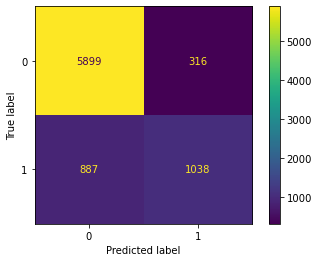

In [188]:
res_df = res_df.append(pd.DataFrame(data=print_cv_metrics(f1_opt_booster), index=['XGB optimized for F1']))

In [189]:
res_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1,AUC
XGB optimized for accuracy,0.855651,0.773324,0.551169,0.643615,0.892074
XGB default,0.856634,0.787994,0.538701,0.639926,0.895065
XGB optimized for F1,0.852211,0.766617,0.539221,0.633120,0.887473
DecisionTree,0.843489,0.735018,0.528831,0.615106,0.866863
RandomForest,0.850614,0.791770,0.499740,0.612739,0.884216
MLP,0.831081,0.685560,0.527792,0.596419,0.865930
logRes,0.826413,0.719931,0.435325,0.542570,0.848562
SVM,0.833538,0.953822,0.311169,0.469252,0.875026


### Submitting first attempt

In [230]:
def pred_to_submit(y_pred):
    aux = pd.DataFrame(data={'income': y_pred})
    aux.index.name = 'Id'
    aux['income'] = aux['income'].map(lambda r: '>50K' if r == 1 else '<=50K')
    return aux

In [227]:
y_pred = acc_opt_booster.predict(test_df)

In [231]:
pred = pred_to_submit(y_pred)

In [232]:
pred

,income
Id,
0,<=50K
1,>50K
2,<=50K
3,<=50K
4,>50K
...,...
16275,<=50K
16276,<=50K
16277,<=50K


In [235]:
pred.to_csv('results/xgboost_optimized_pred.csv')

## Few tweaks to data prep